In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Import data
data = pd.read_csv("./Data/data_trial_1.csv")
data.head()

,0.04,-0.10,0.99,0
0,0.04,-0.10,0.99,0.0
1,0.04,-0.09,0.99,0.0
2,0.04,-0.09,0.99,0.0
3,0.04,-0.10,0.99,0.0
4,0.04,-0.08,0.99,0.0


In [219]:
truncate = 2000 #where we start the data
# end = len(list(data.iloc[:,0]))
end = 6000

x_axis = data.iloc[:,0][truncate:end]
y_axis = data.iloc[:,1][truncate:end]
z_axis = data.iloc[:,2][truncate:end]
break_bool = data.iloc[:,3][truncate:end]
# print(type(y_axis))


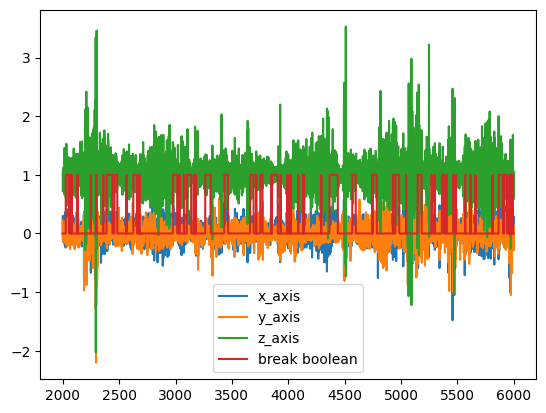

In [220]:
plt.plot(x_axis, label = "x_axis")
plt.plot(y_axis, label = "y_axis")
plt.plot(z_axis, label = "z_axis")
plt.plot(break_bool, label = "break boolean")


plt.legend()
plt.show()


As we can see, our signals are extremely noisy! We need some filtering to get a good result before training a model.

# Wavelet Filter
This is a naive wavelet filtering approach (hint: we don't use this! It's not great)

In [221]:
# Filtering data:
# VERSION 1
def wavelet_denoise(data, wavelet='haar', noise_sigma=0):
    '''Filter accelerometer data using wavelet denoising

    Modification of F. Blanco-Silva's code at: https://goo.gl/gOQwy5
    '''
    import numpy
    import scipy
    import pywt

    wavelet = pywt.Wavelet(wavelet)
    levels  = min(15, (numpy.floor(numpy.log2(data.shape[0]))).astype(int))

    # Francisco's code used wavedec2 for image data
    wavelet_coeffs = pywt.wavedec(data, wavelet, level=levels)
    threshold = noise_sigma*numpy.sqrt(2*numpy.log2(data.size))

    new_wavelet_coeffs = map(lambda x: pywt.threshold(x, threshold, mode='soft'),
                             wavelet_coeffs)

    return pywt.waverec(list(new_wavelet_coeffs), wavelet)

In [222]:
x_new = wavelet_denoise(x_axis, wavelet='haar', noise_sigma=0.05)
y_new = wavelet_denoise(y_axis, wavelet='haar', noise_sigma=0.05)
z_new = wavelet_denoise(z_axis, wavelet='haar', noise_sigma=0.05)



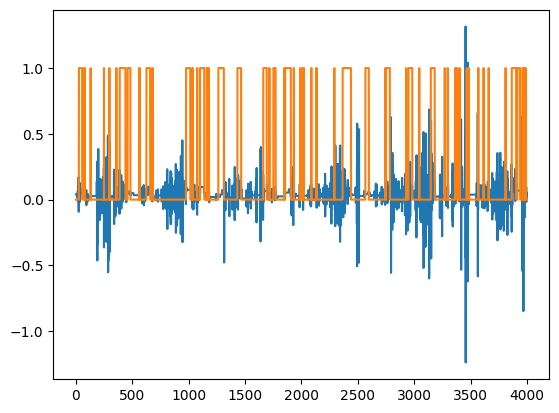

In [223]:
# plt.plot(list(x_axis), label = "x_old")
plt.plot(x_new,label = "x_new")
# plt.plot(y_new,label = "y_new")
# plt.plot(z_new,label = "z_new")

plt.plot(list(break_bool), label = "break boolean")

plt.show()

# Kalman Filter Approach
Using Waveletts doesn't seem to provide much help. As such, let's try using a Kalman filter

In [224]:
import numpy as np
from scipy.linalg import inv

def kalman_filter(data,A,H,Q,R,P):
    """
    Inputs:
    - data (np.array): single dim vector
    - A,H,Q,R,P (np.array): 
        These are the state transition matrix (A), measurement matrix (H), 
        process noise covariance matrix (Q), measurement noise covariance matrix (R), 
        and initial state error covariance matrix (P), respectively.
    Ouputs:
    - y (np.array): filtered version of X
    """
    # Initialize variables
    x = np.array([[data[0]]]) #We start here
    y = np.zeros_like(data) #What we will fill in

    # Run the filter
    for i in range(len(data)):
        # Prediction step
        x = np.dot(A, x)
        P = np.dot(np.dot(A, P), A.T) + Q

        # Update step
        K = np.dot(np.dot(P, H.T), inv(np.dot(np.dot(H, P), H.T) + R))
        x = x + np.dot(K, (data[i] - np.dot(H, x)))
        P = np.dot(np.eye(1) - np.dot(K, H), P)

        # Save the filtered value
        y[i] = x[0, 0]
        #if Nan, set to 0
        if y[i] == 'NaN':
            y[i] = 0

    return y


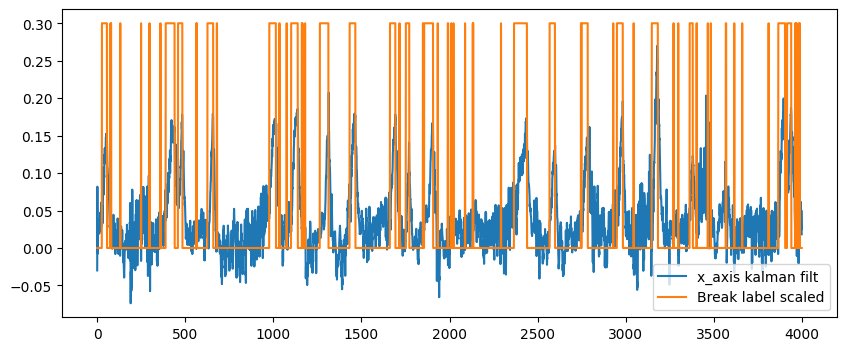

In [225]:

"""
Kalman filter parameters A, H, Q, R, and P.

These are the state transition matrix, measurement matrix, 
process noise covariance matrix, measurement noise covariance matrix, 
and initial state error covariance matrix, respectively.
"""
A = np.array([[1]]) #Set to 1 st x[k+1] = x[k]
H = np.array([[1]]) #y[k] = H * x[k]
Q = np.array([[0.01]]) # Amount of noise
R = np.array([[1]]) # Responsiveness
P = np.array([[1]]) # Est err between pred and actual

x_new_kalman = kalman_filter(np.array(x_axis),A,H,Q,R,P)
y_new_kalman = kalman_filter(np.array(list(y_axis)),A,H,Q,R,P)
z_new_kalman = kalman_filter(np.array(z_axis),A,H,Q,R,P)

plt.figure(figsize=(10,4))
plt.plot([0 if x != x else x for x in x_new_kalman],label = 'x_axis kalman filt')
# plt.plot([0 if x != x else x for x in y_new_kalman],label = 'y_axis kalman filt') #<--- getting a lot of blank values, idk why
plt.plot([x*0.3 for x in list(break_bool)],label = "Break label scaled")
plt.legend()
plt.show()

# Filtering the Binary case:
This looks much better! we can clearly see the breaking and non-breaking. Now, let's filter the break labels. We collected data by manually covering a photoresistor while riding a bike and as such, there are some cases where we didn't threshold correctly but they are momentary. Let's try runing a sliding window that sets sequences of 1s that are to short to all be 0 

In [226]:
def filtBreak(data,min_len):
    """
    This function takes in an 1D array or list of binary data and filters out cases where sequences of 1s
    are less than "min_len" 
    Inputs:
    - data (array or list):
    - min_len ()

    Ouputs:
    - filtered_data (np.array): filtered sequences
    """
    result = []
    count = 0

    for val in data:
        if val == 1:
            count += 1
        else:
            if count < min_len:
                result.extend([0] * count)
            else:
                result.extend([1] * count)
            result.append(val)
            count = 0

    if count < min_len:
        result.extend([0] * count)
    else:
        result.extend([1] * count)
    return result


# Define test inputs
test_data = np.array([1,1,1,0,0,1,0])
min_len = 3

# Define expected output
expected_output = np.array([1,1,1,0,0,0,0])

# Test the function
print(filtBreak(test_data,2))
assert(list(filtBreak(test_data,2))==list(expected_output))

# Print the results
print("Test passed!")
# 

[1, 1, 1, 0, 0, 0, 0]
Test passed!


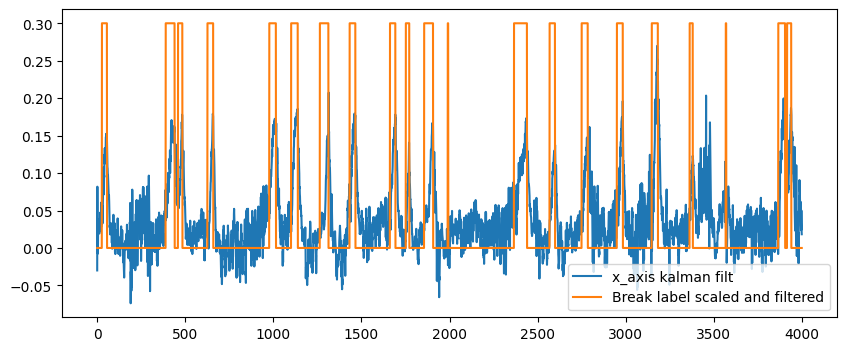

In [227]:
# FILTER our break
min_len = 3
break_bool_filt = filtBreak(list(break_bool),min_len)


plt.figure(figsize=(10,4))
plt.plot([0 if x != x else x for x in x_new_kalman],label = 'x_axis kalman filt')
# plt.plot([x*0.3 for x in list(break_bool)],label = "Break label scaled")
plt.plot([x*0.3 for x in list(break_bool_filt)],label = "Break label scaled and filtered")


plt.legend()
plt.show()

This looks much better! Lets save our results to a csv so we can use this to train a model

In [228]:
# SAVE DATA:
df_raw = {
    'x_va_kalhman_filter':[0 if x != x else x for x in x_new_kalman],
    'binary break label': [x for x in list(break_bool_filt)]
}
df = pd.DataFrame(data=df_raw)
df.to_csv('./Data/train_data1.csv')


### TO DO: This is just a DEMO! DATA IS NOT READY
This is just a demo, we need to still make sure we choose the right parameters. Tweek the window we use, the kalman parameters, and tweek the min_len we use to filter out false positives!!!!